In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import re
import nltk
import spacy
import string
import numpy as np
import pandas as pd
import seaborn as sn
from textblob import TextBlob
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from nltk.corpus import stopwords
from mysutils.text import remove_urls
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize             
from nltk.tokenize import TweetTokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split,RepeatedStratifiedKFold,GridSearchCV,RandomizedSearchCV
# nltk.download('all')
# !python3 -m spacy download en_core_web_sm



2023-02-04 16:47:23.077708: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-04 16:47:23.232163: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-04 16:47:23.808189: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-04 16:47:23.808240: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [3]:
df=pd.read_csv('Elon_musk.csv',encoding='cp1252',usecols=['Text'])
df.head()

,Text
0,@kunalb11 I’m an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
2,@joerogan @Spotify Great interview!
3,@gtera27 Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...


In [4]:
# Lets see most used words

words=[]
for i in df['Text']:
    words.extend(i.split())

words,count=np.unique(words,return_counts=True)

most_used_words=sorted(zip(words,count), key=lambda item: item[1])[::-1]

In [5]:
limit=40
x=[]
y=[]
count=0
for i,j in most_used_words:
    if i[0].isalpha():
        count+=1
        x.append(i)
        y.append(j)
    if count==limit:
        break

In [6]:
fig=go.Figure(go.Bar(x=x,
                     y=y,
                     text=y,
                     marker=dict(color = y,
                                 colorscale='rainbow')))
fig.update_layout(showlegend=False,
                #   margin=dict(l=5, r=1, t=20, b=5),
                  xaxis=dict(
                            title='words',
                            showline=True,
                            showgrid=False,
                            showticklabels=True,
                            linecolor='#05050f'),
                  yaxis=dict(
                            title='counts',
                            showline=True,
                            showgrid=False,
                            showticklabels=True,
                            linecolor='#05050f'),
                  plot_bgcolor='white',
                  title='Most frequent words'
                 )
fig.show()

In [7]:
# Most used user names

limit=40
x=[]
y=[]
count=0
for i,j in most_used_words:
    if i[0].startswith('@'):
        count+=1
        x.append(i)
        y.append(j)
    if count==limit:
        break

fig=go.Figure(go.Bar(x=x,
                     y=y,
                     text=y,
                     marker=dict(color = y,
                                 colorscale='rainbow')))
fig.update_layout(showlegend=False,
                #   margin=dict(l=5, r=1, t=20, b=5),
                  xaxis=dict(
                            title='@user_names',
                            showline=True,
                            showgrid=False,
                            showticklabels=True,
                            linecolor='#05050f'),
                  yaxis=dict(
                            title='counts',
                            showline=True,
                            showgrid=False,
                            showticklabels=True,
                            linecolor='#05050f'),
                  plot_bgcolor='white',
                  title='Most frequent @user_names'
                 )
fig.show()

In [8]:
# Most used #tags

limit=40
x=[]
y=[]
count=0
for i,j in most_used_words:
    if i[0].startswith('#'):
        count+=1
        x.append(i)
        y.append(j)
    if count==limit:
        break

fig=go.Figure(go.Bar(x=x,
                     y=y,
                     text=y,
                     marker=dict(color = y,
                                 colorscale='rainbow')))
fig.update_layout(showlegend=False,
                #   margin=dict(l=5, r=1, t=20, b=5),
                  xaxis=dict(
                            title='tags',
                            showline=True,
                            showgrid=False,
                            showticklabels=True,
                            linecolor='#05050f'),
                  yaxis=dict(
                            title='counts',
                            showline=True,
                            showgrid=False,
                            showticklabels=True,
                            linecolor='#05050f'),
                  plot_bgcolor='white',
                  title='Most frequent #tags'
                 )
fig.show()

In [9]:
# creating new_df with all lower case
new_df=pd.DataFrame(df['Text'].apply(lambda x : x.strip().lower()))
new_df.head()

,Text
0,@kunalb11 i’m an alien
1,@id_aa_carmack ray tracing on cyberpunk with h...
2,@joerogan @spotify great interview!
3,@gtera27 doge is underestimated
4,@teslacn congratulations tesla china for amazi...


In [10]:
# Checking duplicate rows
new_df[new_df.duplicated()]

,Text
324,the most entertaining outcome is the most likely
655,@westcoastbill indeed


In [11]:
# removing them
new_df.drop_duplicates(inplace=True)

In [12]:
new_df.shape

(1997, 1)

In [13]:
# Lets see all unique first letters
print(set([x[0] for x in new_df['Text']]))

{'9', 'x', 'a', '2', 'f', 'v', 'c', '4', 'p', 'g', 'w', 'i', '@', '“', 'q', 'r', 'b', 'm', 'u', 't', 'e', 'y', '5', '1', 'd', 'l', '.', 's', 'j', '<', 'ð', '0', 'h', 'o', 'n'}


In [14]:
# Lets see how many of them starts with @
len(new_df[new_df['Text'].str.contains('@')])

1677

Here we have some user tags, links, emojis, <...> 

In [15]:
fig=go.Figure(go.Pie(labels=['contains @','Others'],values=[1678,1999-1678],pull=[0,0.1]))
fig.update_layout(autosize=False,title='Tweets with user tags')
fig.show()

In [16]:
# How many of them contains links 
count=len(new_df[new_df['Text'].str.contains('https://')])
fig=go.Figure(go.Pie(labels=['Contains URLs','Others'],values=[count,1999-count],pull=[0,0.1]))
fig.update_layout(autosize=False,title='Tweets with URLs')
fig.show()

In [17]:
new_df

,Text
0,@kunalb11 i’m an alien
1,@id_aa_carmack ray tracing on cyberpunk with h...
2,@joerogan @spotify great interview!
3,@gtera27 doge is underestimated
4,@teslacn congratulations tesla china for amazi...
...,...
1994,"@flcnhvy true, it sounds so surreal, but the n..."
1995,@ppathole make sure to read ur terms &amp; con...
1996,@teslagong @ppathole samwise gamgee
1997,@ppathole altho dumb and dumber is <u+0001f525...


In [18]:
# Analyzing the words
nlp=spacy.load('en_core_web_sm')

In [19]:
# make tweets to single txt/string
tweet_txt = ''
for i in new_df['Text']:
    tweet_txt = (tweet_txt + i ).strip()+ ' '
    

In [20]:
tweet_txt=nlp(tweet_txt)


In [21]:
# A dictionary that store all the POS( Parts of speech)
a_count_dict=dict()

for i in tweet_txt:
    if i.pos_ in a_count_dict.keys():
        a_count_dict[i.pos_] += 1
    else:
        a_count_dict[i.pos_] = 1

In [22]:
# These are all parts of speech we have
a_count_dict

{'PROPN': 3380,
 'PRON': 1279,
 'VERB': 2407,
 'DET': 1135,
 'ADJ': 2003,
 'NOUN': 5152,
 'ADP': 1708,
 'AUX': 1298,
 'PUNCT': 2887,
 'X': 615,
 'ADV': 1230,
 'SPACE': 90,
 'INTJ': 244,
 'PART': 469,
 'SCONJ': 259,
 'CCONJ': 502,
 'NUM': 441,
 'SYM': 82}

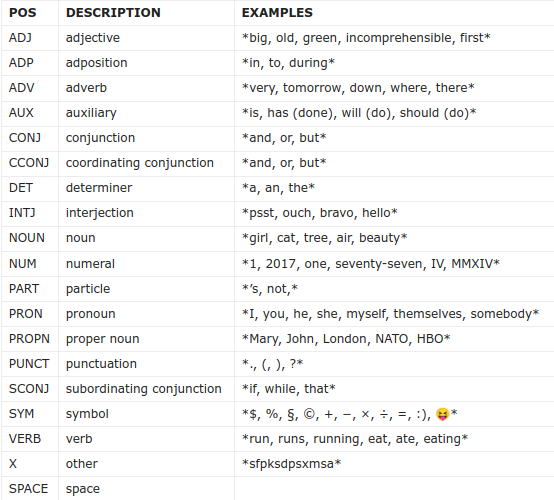

In [23]:
x=list(a_count_dict.values())
y=list(a_count_dict.keys())
fig=go.Figure(go.Bar(x=x,
                     y=y,
                     text=x,
                     orientation='h',
                     marker=dict(color=x,
                                    colorscale='dense') ))
fig.update_layout(title='POS count')
fig.show()

In [24]:
# defining a function to clean our string

def clean_it (txt):
  emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)

  txt = re.sub('rt', '', txt) # remove 'RT' from tweets
  txt = re.sub('#[a-z0-9]+', '', txt) # remove the '#' from the tweets
  txt = re.sub('\\n', '', txt) # remove the '\n' character
  txt = re.sub('https?:\/\/\S+', '', txt) # remove the hyperlinks
  txt = re.sub('@[\S]*', '', txt) # remove @mentions
  txt = re.sub('^[\s]+|[\s]+$', '', txt) # remove leading and trailing whitespaces
  txt = re.sub(emoj, '', txt) # remove emojis
  txt = re.sub('[^a-z ]','',txt) #removes everything except alphabets
  return [x.strip() for x in txt.split()]

In [25]:
new_df['cleaned tweets']=new_df['Text'].apply(clean_it)
new_df.head()

,Text,cleaned tweets
0,@kunalb11 i’m an alien,"[im, an, alien]"
1,@id_aa_carmack ray tracing on cyberpunk with h...,"[ray, tracing, on, cyberpunk, with, hdr, is, n..."
2,@joerogan @spotify great interview!,"[great, interview]"
3,@gtera27 doge is underestimated,"[doge, is, underestimated]"
4,@teslacn congratulations tesla china for amazi...,"[congratulations, tesla, china, for, amazing, ..."


In [26]:
# Now removing empty tweets if any
new_df=new_df[new_df['cleaned tweets']!='']

In [27]:
# removing 'im' as we dont need them
# Also single word are not needed
new_df['cleaned tweets']=new_df['cleaned tweets'].apply(lambda x: [x for x in x if (x!='im') and (len(x)>1)])

In [28]:
# Now we have to correct all spelling mistakes 
# new_df['cleaned tweets']=new_df['cleaned tweets'].apply(lambda x: )

In [29]:

TextBlob('doge').correct()

TextBlob("done")

In [30]:
# Will not use correct spellling as its not robust

In [31]:
# Now removing stop words
new_df['cleaned tweets']=new_df['cleaned tweets'].apply(lambda y: [y for y in y if y not in set(stopwords.words('english'))] )

In [32]:
new_df

,Text,cleaned tweets
0,@kunalb11 i’m an alien,[alien]
1,@id_aa_carmack ray tracing on cyberpunk with h...,"[ray, tracing, cyberpunk, hdr, nextlevel, tried]"
2,@joerogan @spotify great interview!,"[great, interview]"
3,@gtera27 doge is underestimated,"[doge, underestimated]"
4,@teslacn congratulations tesla china for amazi...,"[congratulations, tesla, china, amazing, execu..."
...,...,...
1994,"@flcnhvy true, it sounds so surreal, but the n...","[true, sounds, surreal, negative, propaganda, ..."
1995,@ppathole make sure to read ur terms &amp; con...,"[make, sure, read, ur, terms, amp, conditions,..."
1996,@teslagong @ppathole samwise gamgee,"[samwise, gamgee]"
1997,@ppathole altho dumb and dumber is <u+0001f525...,"[altho, dumb, dumber, ufuf]"


In [33]:
# Now using lemmatizer
new_df['cleaned tweets']=new_df['cleaned tweets'].apply(lambda x: ' '.join([WordNetLemmatizer().lemmatize(y).strip() for y in x]) )

In [34]:
new_df

,Text,cleaned tweets
0,@kunalb11 i’m an alien,alien
1,@id_aa_carmack ray tracing on cyberpunk with h...,ray tracing cyberpunk hdr nextlevel tried
2,@joerogan @spotify great interview!,great interview
3,@gtera27 doge is underestimated,doge underestimated
4,@teslacn congratulations tesla china for amazi...,congratulation tesla china amazing execution l...
...,...,...
1994,"@flcnhvy true, it sounds so surreal, but the n...",true sound surreal negative propaganda still a...
1995,@ppathole make sure to read ur terms &amp; con...,make sure read ur term amp condition clicking ...
1996,@teslagong @ppathole samwise gamgee,samwise gamgee
1997,@ppathole altho dumb and dumber is <u+0001f525...,altho dumb dumber ufuf


In [35]:
SIA = SentimentIntensityAnalyzer()

In [36]:
# new_df[['neg','neu','pos','compound']]=new_df['cleaned tweets'].apply(lambda x: pd.Series(SIA.polarity_scores(x).values()))

In [37]:
new_df['compound'] = new_df['cleaned tweets'].apply(lambda x: SIA.polarity_scores(x)['compound'])

In [38]:
new_df.head()

,Text,cleaned tweets,compound
0,@kunalb11 i’m an alien,alien,0.0000
1,@id_aa_carmack ray tracing on cyberpunk with h...,ray tracing cyberpunk hdr nextlevel tried,0.0000
2,@joerogan @spotify great interview!,great interview,0.6249
3,@gtera27 doge is underestimated,doge underestimated,-0.2732
4,@teslacn congratulations tesla china for amazi...,congratulation tesla china amazing execution l...,0.8271


In [39]:
# So here we can specify those tweets as positive where
# compound value is greater than 0
# if it is 0 then we can say it is neutral
# else negetive

new_df['Type']=new_df.compound.apply(lambda x: 'Negative' if x < 0 else 'Neutral' if x == 0 else 'Positive')

In [40]:
new_df.head()

,Text,cleaned tweets,compound,Type
0,@kunalb11 i’m an alien,alien,0.0000,Neutral
1,@id_aa_carmack ray tracing on cyberpunk with h...,ray tracing cyberpunk hdr nextlevel tried,0.0000,Neutral
2,@joerogan @spotify great interview!,great interview,0.6249,Positive
3,@gtera27 doge is underestimated,doge underestimated,-0.2732,Negative
4,@teslacn congratulations tesla china for amazi...,congratulation tesla china amazing execution l...,0.8271,Positive


In [41]:
type(new_df.Type.value_counts())

pandas.core.series.Series

In [42]:
# Checking the distribution of types
temp_df=new_df.Type.value_counts()
fig=go.Figure(go.Pie(labels=temp_df.index, values=temp_df.values))
fig.update_layout(title_text="Distribution of Types",
                  autosize=False)
fig.show()

In [43]:
# Compound value accross the dataframe
fig=go.Figure(go.Scatter(x=new_df.index, y=new_df.compound))
fig.update_layout(
                  xaxis=dict(
                            title='index'),
                  yaxis=dict(
                            title='compound'),
                  title='Compound value'
                 )
fig.show()

Seems like most of the tweets are positive

In [44]:
new_df

,Text,cleaned tweets,compound,Type
0,@kunalb11 i’m an alien,alien,0.0000,Neutral
1,@id_aa_carmack ray tracing on cyberpunk with h...,ray tracing cyberpunk hdr nextlevel tried,0.0000,Neutral
2,@joerogan @spotify great interview!,great interview,0.6249,Positive
3,@gtera27 doge is underestimated,doge underestimated,-0.2732,Negative
4,@teslacn congratulations tesla china for amazi...,congratulation tesla china amazing execution l...,0.8271,Positive
...,...,...,...,...
1994,"@flcnhvy true, it sounds so surreal, but the n...",true sound surreal negative propaganda still a...,-0.0000,Neutral
1995,@ppathole make sure to read ur terms &amp; con...,make sure read ur term amp condition clicking ...,0.5994,Positive
1996,@teslagong @ppathole samwise gamgee,samwise gamgee,0.0000,Neutral
1997,@ppathole altho dumb and dumber is <u+0001f525...,altho dumb dumber ufuf,-0.7003,Negative


In [45]:
# Lets see word_count vs compound

fig=go.Figure(go.Scatter(x=new_df['Text'].apply(lambda x: len(x.split())), y=new_df.compound,mode='markers'))
fig.update_layout(xaxis=dict(
                            title='word count'),
                  yaxis=dict(
                            title='compound'),
                  title='word count vs compound',
                  autosize=False
                 )
fig.show()

In [46]:
# Now Vectorize our words/tweets

# Using CountVectorizer
CV=CountVectorizer()


In [47]:
(CV.fit_transform(new_df['cleaned tweets'])).toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [48]:
# Splitting our data so as to ready for model building
x_train,x_test,y_train,y_test=train_test_split((CV.fit_transform(new_df['cleaned tweets'])).toarray(),new_df['Type'].apply(lambda x:{'Neutral':2,'Positive':3,'Negative':1}[x]))

In [49]:
classifiers = {
    "MultinomialNB": MultinomialNB(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "LogisticRegression": LogisticRegression(),
    "MLPClassifier": MLPClassifier(max_iter=1000),
    "AdaBoostClassifier": AdaBoostClassifier(),
}

In [50]:
for Algo, sklearn_classifier in classifiers.items():
    classifier = sklearn_classifier
    classifier.fit(x_train,y_train)
    
    print(f"{Algo} : Train- {accuracy_score(y_train,classifier.predict(x_train)):.2f}, Test- {accuracy_score(y_test,classifier.predict(x_test)):.2f}")

MultinomialNB : Train- 0.95, Test- 0.72
KNeighborsClassifier : Train- 0.65, Test- 0.61
DecisionTreeClassifier : Train- 1.00, Test- 0.79
RandomForestClassifier : Train- 1.00, Test- 0.81
LogisticRegression : Train- 0.98, Test- 0.77
MLPClassifier : Train- 1.00, Test- 0.79
AdaBoostClassifier : Train- 0.78, Test- 0.71


Seems like DecisionTree performs well here<br>

In [51]:
def check_my_scores(single_params,param_grid={}):
    keys = list(single_params.keys())[0]
    values= list(single_params.values())[0]


    train_scores=[]
    test_scores=[]

    for i in values:
        single_params[keys]=i
        tree_model= DecisionTreeClassifier(random_state=11,**single_params,**param_grid).fit(x_train,y_train)

        train_scores.append(accuracy_score(y_train,tree_model.predict(x_train)))
        test_scores.append(accuracy_score(y_test,tree_model.predict(x_test)))

    fig=go.Figure()
    fig.add_scatter(x=values, y=train_scores,name='train')
    fig.add_scatter(x=values, y=test_scores,name='test')
    fig.update_layout(hovermode='x unified')
    fig.show()


In [52]:
check_my_scores({'max_depth':np.arange(1,20)})

choosing max_depth= 7

In [53]:
check_my_scores({'min_samples_split':np.arange(60,80)},{'max_depth':7})

choosing min_sample_split = 62

In [54]:
model=DecisionTreeClassifier(random_state=11,max_depth=7,min_samples_split=62)

In [55]:
model.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=7, min_samples_split=62, random_state=11)

In [56]:
# Classification report on train set
print(classification_report(y_train,model.predict(x_train)))

              precision    recall  f1-score   support

           1       1.00      0.01      0.03       153
           2       0.56      1.00      0.72       675
           3       0.98      0.42      0.59       669

    accuracy                           0.64      1497
   macro avg       0.85      0.48      0.45      1497
weighted avg       0.79      0.64      0.59      1497



In [57]:
# Classification report on test set
print(classification_report(y_test,model.predict(x_test)))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        48
           2       0.58      1.00      0.74       248
           3       0.96      0.36      0.52       204

    accuracy                           0.64       500
   macro avg       0.52      0.45      0.42       500
weighted avg       0.68      0.64      0.58       500



<AxesSubplot: title={'center': 'Test set'}>

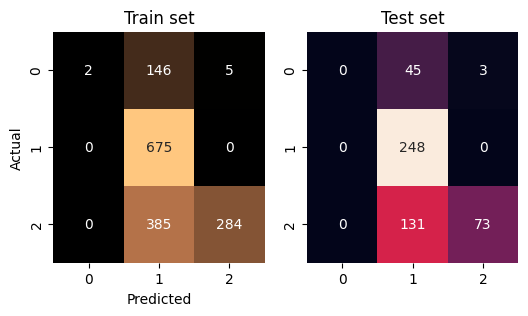

In [58]:
# Confussion metrix
plt.figure(figsize=(6,3))
plt.subplot(1,2,1,title='Train set')
sn.heatmap(confusion_matrix(y_train,model.predict(x_train)),annot=True,fmt=".0f",cmap='copper',cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.subplot(1,2,2,title='Test set')
sn.heatmap(confusion_matrix(y_test,model.predict(x_test)),annot=True,fmt=".0f",cbar=False)